In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

In [2]:
# Load the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

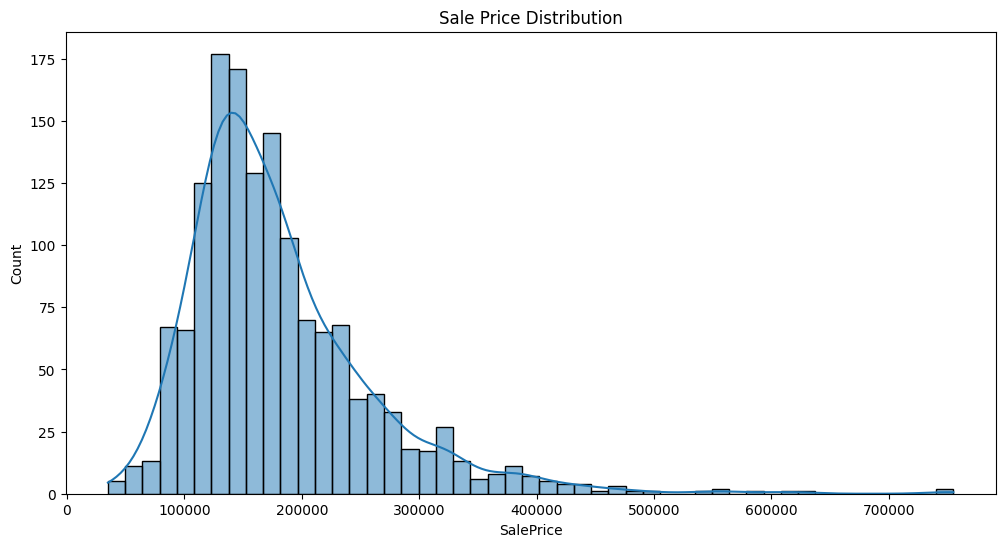

In [3]:
# EDA
plt.figure(figsize=(12, 6))
sns.histplot(train['SalePrice'], kde=True)
plt.title('Sale Price Distribution')
plt.show()

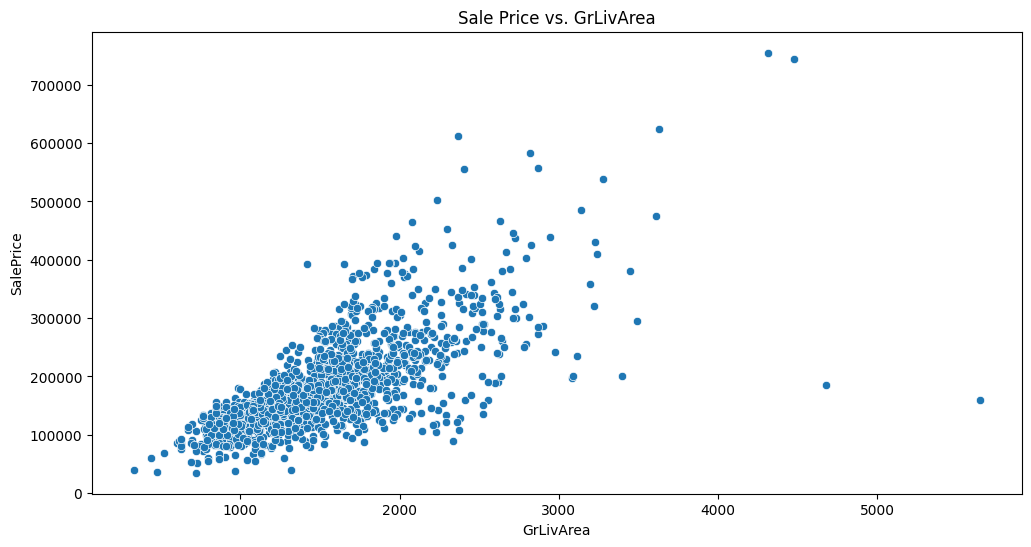

In [4]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=train['GrLivArea'], y=train['SalePrice'])
plt.title('Sale Price vs. GrLivArea')
plt.show()

<ipython-input-5-386cbe807364>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train.corr()


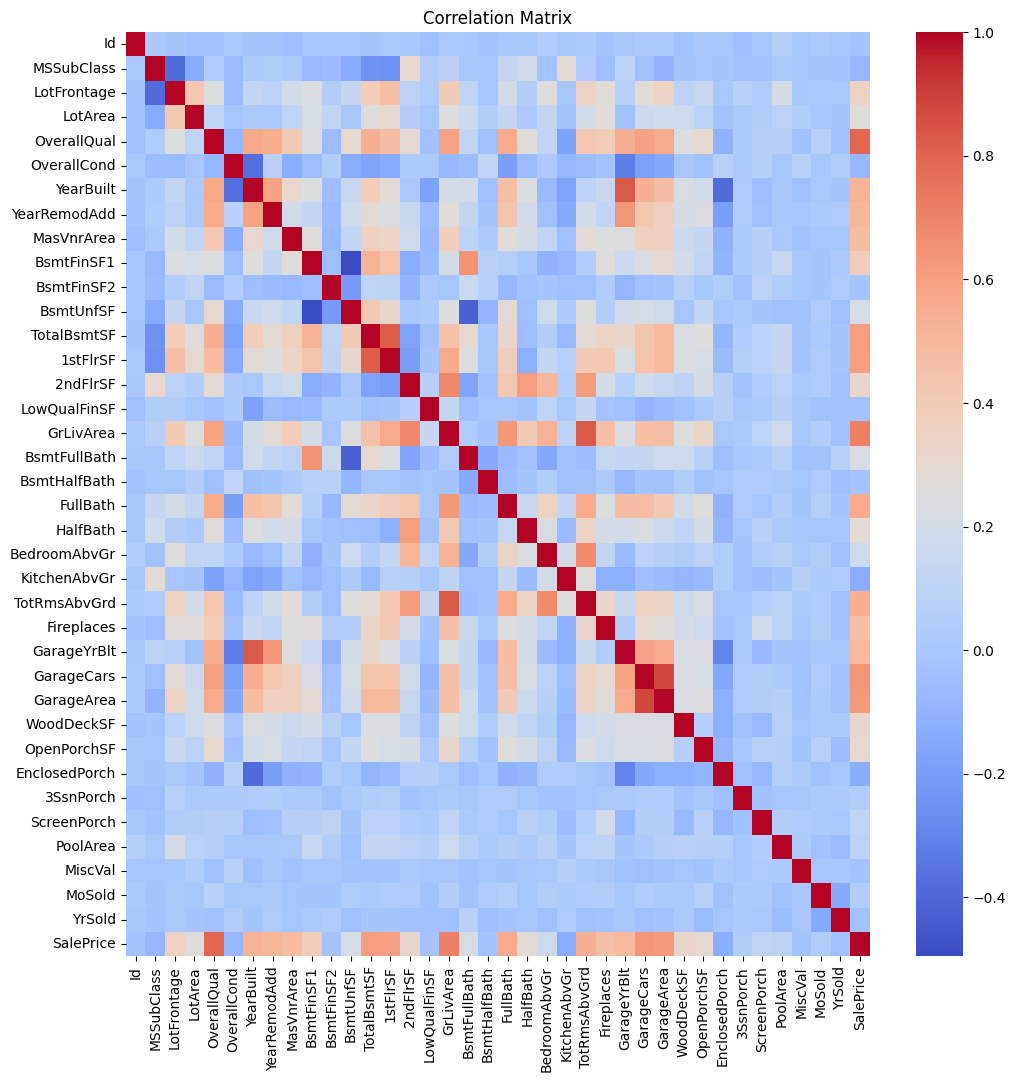

In [5]:
correlation_matrix = train.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix')
plt.show()

In [6]:
# Identify categorical and numerical columns
categorical_columns = train.select_dtypes(include=['object']).columns
numerical_columns = train.select_dtypes(exclude=['object']).drop(['Id', 'SalePrice'], axis=1).columns

In [7]:
# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numerical_columns),
        ('cat', Pipeline(steps=[
            ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_columns)])

In [8]:
# Prepare the data
X_train = train.drop(['Id', 'SalePrice'], axis=1)
y_train = train['SalePrice']
X_test = test.drop(['Id'], axis=1)

In [9]:
# Preprocess the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [10]:
# Feature scaling
scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# Define base models for stacking
base_models = [
    ('random_forest', RandomForestRegressor(n_jobs=-1, random_state=42)),
    ('xgb_regressor', XGBRegressor(n_jobs=-1, random_state=42)),
    ('lasso', Lasso(max_iter=10000, random_state=42))
]

In [12]:
# Set up stacking regressor
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=Lasso(max_iter=10000, random_state=42), n_jobs=-1)

In [13]:
# Perform KFold cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)
rmse_scores = np.sqrt(-cross_val_score(stacking_regressor, X_train, y_train, scoring='neg_mean_squared_error', cv=kf))

In [14]:
# Print mean and standard deviation of RMSE scores
print(f"KFold Cross-Validation RMSE scores: {rmse_scores}")
print(f"Mean RMSE score: {rmse_scores.mean():.2f}")
print(f"Standard deviation of RMSE scores: {rmse_scores.std():.2f}")

KFold Cross-Validation RMSE scores: [26911.27537356 27797.82787313 46316.24127646 25608.43799687
 21896.72056903]
Mean RMSE score: 29706.10
Standard deviation of RMSE scores: 8545.49


In [15]:
# Train the stacking model
stacking_regressor.fit(X_train, y_train)

StackingRegressor(estimators=[('random_forest',
                               RandomForestRegressor(n_jobs=-1,
                                                     random_state=42)),
                              ('xgb_regressor',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, g...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=42, ...)),
                              ('lasso',
                               Lasso(max_iter=10000, random_state=42))],
                  final_estimator=Lasso(max_iter=10000, random_state=42),
                  n_jobs=-1)

In [16]:
# Generate predictions
predictions = stacking_regressor.predict(X_test)

In [17]:
# Create the submission file
submission = pd.DataFrame({'Id': test['Id'], 'SalePrice': predictions})
submission.to_csv('submission.csv', index=False)

print("Submission file created.")

Submission file created.



This code includes EDA with data visualization, preprocessing, model stacking using RandomForestRegressor, XGBRegressor, and Lasso as base models, and a Lasso model as the final estimator. The code performs KFold cross-validation and trains the stacking model. Finally, it generates predictions and creates the submission file.
